<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment_02_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [ ]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## EDA Functions

In [ ]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [ ]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [ ]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [ ]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [ ]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels 

In [ ]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [ ]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [ ]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

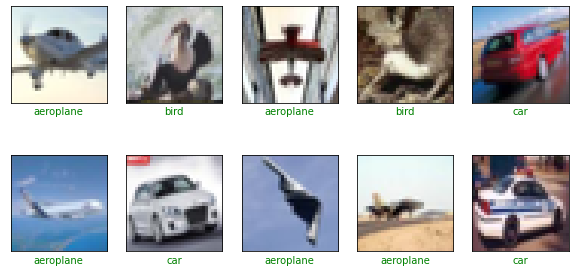

In [ ]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [ ]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [ ]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [ ]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [ ]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

print(x_train_norm.shape, x_valid_norm.shape, x_test_norm.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


##Experiment 1: DNN with 2 layers (no regularization)

Hidden layer 1: 100 neurons

Hidden layer 2: 150 neurons

Ouput layer: 10 neurons (one for each image)

####Build, Compile, Train, Evaluate

In [ ]:
## Variation 1 - did not train
#model_1 = Sequential()
#model_1.add(Dense(input_shape = [32,32,3], units = 100, activation = 'relu', ))
#model_1.add(Dense(units = 150, activation = 'relu'))
#model_1.add(Dense(name = "output_layer", units = 10, activation = 'softmax'))
#model_1.summary()

In [ ]:
## Variation 2 - trained 
model_1 = Sequential()
model_1.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_1.add(layers.Dense(units = 100, activation = "relu"))
model_1.add(layers.Dense(units = 150, activation = "relu"))
model_1.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-trainable params: 0
_________________________________________________________________


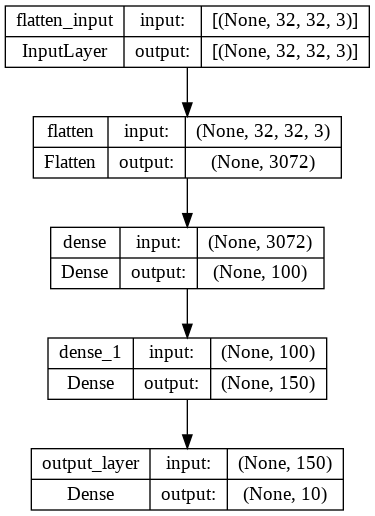

In [ ]:
keras.utils.plot_model(model_1, "CIFAR_model.png", show_shapes=True) 

In [ ]:
## Compile

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 

history_1 = model_1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 5s 3ms/step - loss: 1.8726 - accuracy: 0.3275 - val_loss: 1.7718 - val_accuracy: 0.3614
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6961 - accuracy: 0.3898 - val_loss: 1.6665 - val_accuracy: 0.3994
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6202 - accuracy: 0.4210 - val_loss: 1.5952 - val_accuracy: 0.4224
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5617 - accuracy: 0.4419 - val_loss: 1.6011 - val_accuracy: 0.4210
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5274 - accuracy: 0.4513 - val_loss: 1.6011 - val_accuracy: 0.4250
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4916 - accuracy: 0.4664 - val_loss: 1.5677 - val_accuracy: 0.4378
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4702 - accuracy: 0.4763 - val_loss: 1.5292 - val_accuracy: 0.4542

In [ ]:
## Evaluate

model_1 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_1.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4277 - accuracy: 0.4916
Test acc: 0.492


#### Plot Metrics

In [ ]:
history_dict_1 = history_1.history
history_dict_1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df_1=pd.DataFrame(history_dict_1)
history_df_1.tail().round(3)

loss  accuracy  val_loss  val_accuracy
17  1.318     0.529     1.493         0.467
18  1.309     0.532     1.464         0.480
19  1.300     0.534     1.504         0.459
20  1.299     0.538     1.489         0.467
21  1.287     0.542     1.486         0.466

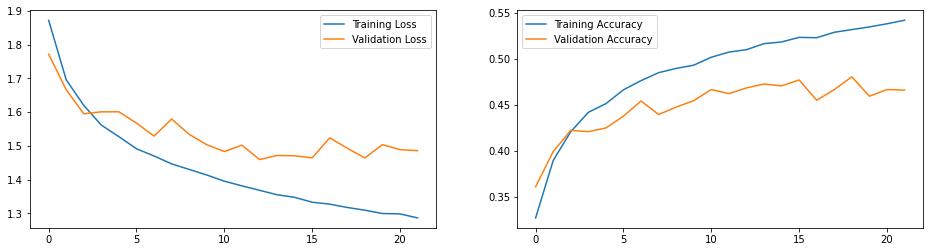

In [ ]:
## Loss and acuracy
plot_history(history_1)

In [ ]:
## Confusion matrix
pred_1= model_1.predict(x_test_norm)
pred_1=np.argmax(pred_1, axis=1)

313/313 [==============================] - 0s 1ms/step


313/313 [==============================] - 0s 1ms/step


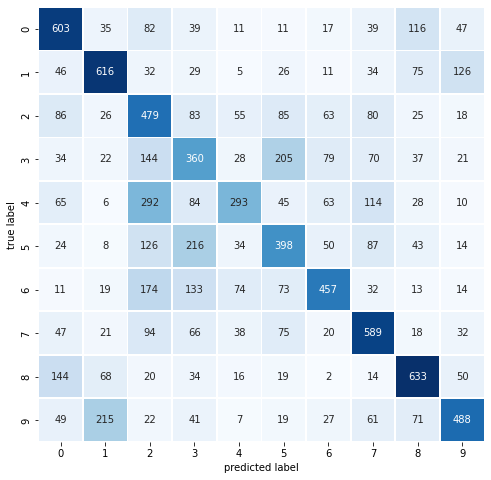

In [ ]:
# Get the predicted classes:
pred_classes_1 = np.argmax(model_1.predict(x_test_norm), axis=-1)
pred_classes_1;

conf_mx_1 = tf.math.confusion_matrix(y_test, pred_classes_1)
conf_mx_1;

plot_confusion_matrix(y_test,pred_classes_1)

#### Activation and Performance

In [ ]:
# Extracts the outputs of all layers:
layer_outputs_1 = [layer.output for layer in model_1.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_1 = models.Model(inputs=model_1.input, outputs=layer_outputs_1)

# Get activation values for the last dense layer
activations_1 = activation_model_1.predict(x_valid_norm[:3250])
dense_layer_activations_1 = activations_1[-3]
output_layer_activations_1 = activations_1[-1]

102/102 [==============================] - 0s 1ms/step


In [ ]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_1 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_1 = tsne_1.fit_transform(dense_layer_activations_1)

# Scaling
tsne_results_1 = (tsne_results_1 - tsne_results_1.min()) / (tsne_results_1.max() - tsne_results_1.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 3250 samples in 0.228s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 5.535911
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.640274
[t-SNE] KL divergence after 300 iterations: 2.425277


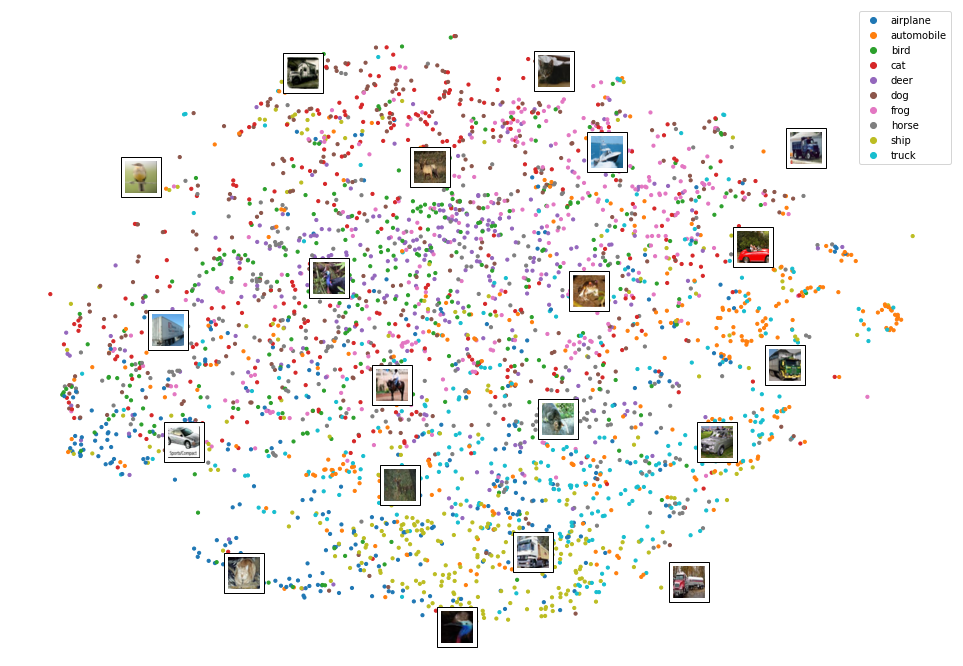

In [ ]:
cmap_1 = plt.cm.tab10
plt.figure(figsize=(17,12))
scatter_1 = plt.scatter(tsne_results_1[:,0],tsne_results_1[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_1)
plt.legend(handles=scatter_1.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_1):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##Experiment 2: DNN with 3 layers (no regularization)

Hidden layer 1: 100

Hidden layer 2: 150

Hidden layer 3: 75

Output layer: 10 (one for each image)

#### Build, Compile, Train, Evaluate

In [ ]:
model_2 = Sequential()
model_2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_2.add(layers.Dense(units = 100, activation = "relu"))
model_2.add(layers.Dense(units = 250, activation = "relu"))
model_2.add(layers.Dense(units = 150, activation = "relu"))
model_2.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               307300    
                                                                 
 dense_3 (Dense)             (None, 250)               25250     
                                                                 
 dense_4 (Dense)             (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


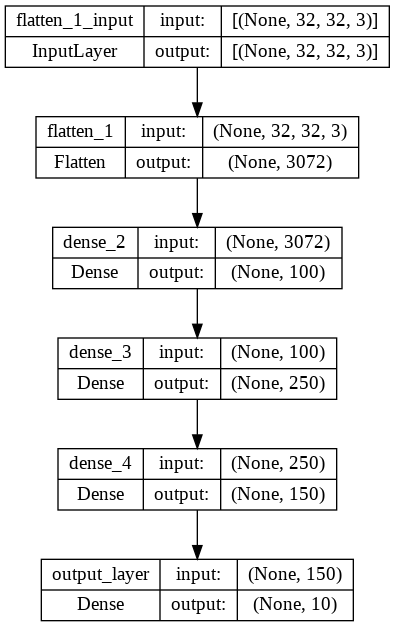

In [ ]:
keras.utils.plot_model(model_2, "CIFAR_model.png", show_shapes=True) 

In [ ]:
## Compile

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 

history_2 = model_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 1.8538 - accuracy: 0.3241 - val_loss: 1.7773 - val_accuracy: 0.3578
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6851 - accuracy: 0.3944 - val_loss: 1.6692 - val_accuracy: 0.3938
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6074 - accuracy: 0.4229 - val_loss: 1.6387 - val_accuracy: 0.4192
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5525 - accuracy: 0.4432 - val_loss: 1.5828 - val_accuracy: 0.4242
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5148 - accuracy: 0.4572 - val_loss: 1.5847 - val_accuracy: 0.4288
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4852 - accuracy: 0.4696 - val_loss: 1.5410 - val_accuracy: 0.4464
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4560 - accuracy: 0.4784 - val_loss: 1.5415 - val_accuracy: 0.4462

In [ ]:
## Evaluate

model_2 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4516 - accuracy: 0.4870
Test acc: 0.487


#### Plot Metrics

In [ ]:
history_dict_2 = history_2.history
history_dict_2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df_2=pd.DataFrame(history_dict_2)
history_df_2.tail().round(3)

loss  accuracy  val_loss  val_accuracy
13  1.328     0.526     1.523         0.461
14  1.314     0.528     1.499         0.473
15  1.298     0.533     1.515         0.469
16  1.287     0.539     1.507         0.466
17  1.272     0.544     1.530         0.463

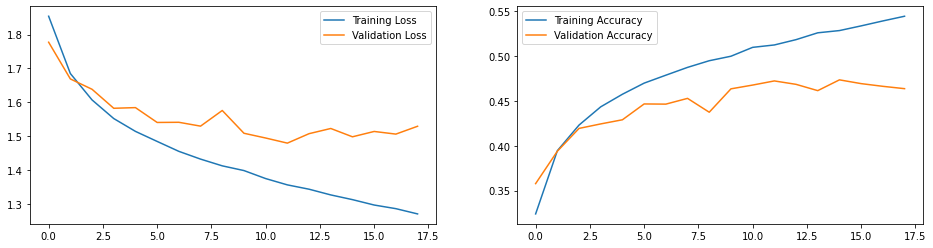

In [ ]:
## Loss and acuracy
plot_history(history_2)

In [ ]:
## Confusion matrix
pred_2= model_2.predict(x_test_norm)
pred_2=np.argmax(pred_2, axis=1)

313/313 [==============================] - 0s 1ms/step


313/313 [==============================] - 0s 1ms/step


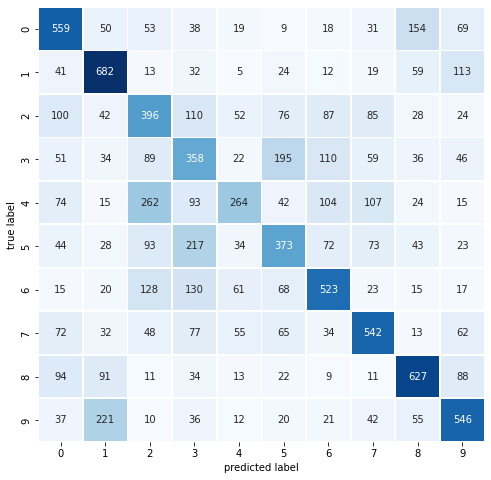

In [ ]:
# Get the predicted classes:
pred_classes_2 = np.argmax(model_2.predict(x_test_norm), axis=-1)
pred_classes_2;

conf_mx_2 = tf.math.confusion_matrix(y_test, pred_classes_2)
conf_mx_2;

plot_confusion_matrix(y_test,pred_classes_2)

#### Activation and Performance

In [ ]:
# Extracts the outputs of all layers:
layer_outputs_2 = [layer.output for layer in model_2.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_2 = models.Model(inputs=model_2.input, outputs=layer_outputs_2)

# Get activation values for the last dense layer
activations_2 = activation_model_2.predict(x_valid_norm[:3250])
dense_layer_activations_2 = activations_2[-3]
output_layer_activations_2 = activations_2[-1]

102/102 [==============================] - 0s 2ms/step


In [ ]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_2 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_2 = tsne_2.fit_transform(dense_layer_activations_2)

# Scaling
tsne_results_2 = (tsne_results_2 - tsne_results_2.min()) / (tsne_results_2.max() - tsne_results_2.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 3250 samples in 0.278s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 2.929008
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.782166
[t-SNE] KL divergence after 300 iterations: 2.295464


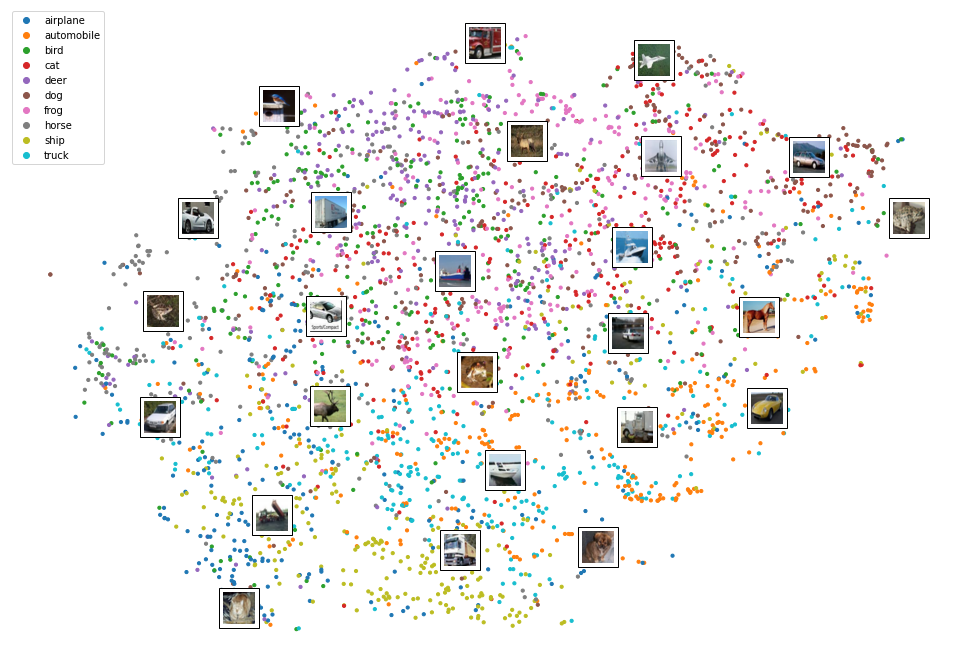

In [ ]:
cmap_2 = plt.cm.tab10
plt.figure(figsize=(17,12))
scatter_2 = plt.scatter(tsne_results_2[:,0],tsne_results_2[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_2)
plt.legend(handles=scatter_2.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_2):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

Layer 1: 128

Layer 2: 256

Layer: 384

#### Build, Compile, Train, Evaluate

In [ ]:
## Build CNN

model_3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_5 (Dense)             (None, 384)              

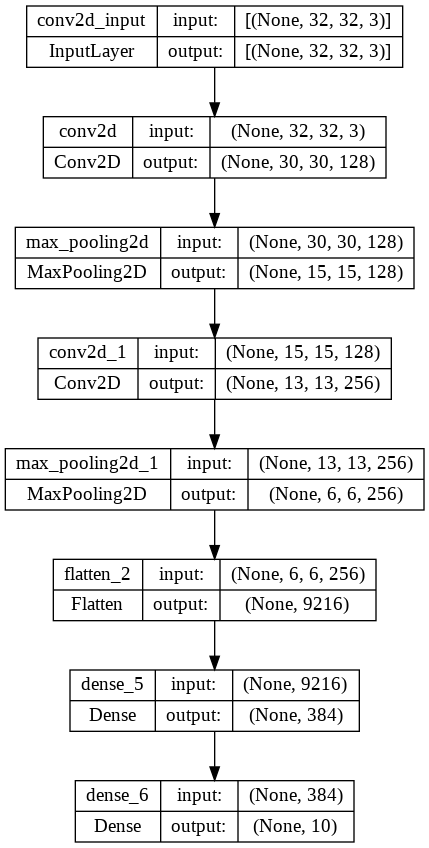

In [ ]:
keras.utils.plot_model(model_3, "CIFAR10.png", show_shapes=True) 

In [ ]:
## Compile

model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 

history_3 = model_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 13s 10ms/step - loss: 2.1693 - accuracy: 0.1671 - val_loss: 2.0641 - val_accuracy: 0.1754
Epoch 2/200
704/704 [==============================] - 7s 9ms/step - loss: 2.0045 - accuracy: 0.1858 - val_loss: 1.9628 - val_accuracy: 0.1940
Epoch 3/200
704/704 [==============================] - 7s 9ms/step - loss: 1.9085 - accuracy: 0.2426 - val_loss: 1.8732 - val_accuracy: 0.2534
Epoch 4/200
704/704 [==============================] - 7s 9ms/step - loss: 1.8089 - accuracy: 0.2727 - val_loss: 1.7727 - val_accuracy: 0.2804
Epoch 5/200
704/704 [==============================] - 7s 9ms/step - loss: 1.7320 - accuracy: 0.2867 - val_loss: 1.7105 - val_accuracy: 0.2826
Epoch 6/200
704/704 [==============================] - 7s 9ms/step - loss: 1.6779 - accuracy: 0.3004 - val_loss: 1.6804 - val_accuracy: 0.2976
Epoch 7/200
704/704 [==============================] - 7s 9ms/step - loss: 1.6398 - accuracy: 0.3132 - val_loss: 1.6755 - val_accuracy: 0.30

In [ ]:
## Evaluate

model_3 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4516 - accuracy: 0.4870
Test acc: 0.487


#### Plot Metrics

In [ ]:
history_dict_3 = history_3.history
history_dict_3.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df_3=pd.DataFrame(history_dict_3)
history_df_3.tail().round(3)

loss  accuracy  val_loss  val_accuracy
34  0.627     0.819     1.173         0.660
35  0.605     0.828     1.179         0.672
36  0.579     0.841     1.177         0.665
37  0.570     0.845     1.212         0.671
38  0.549     0.853     1.231         0.665

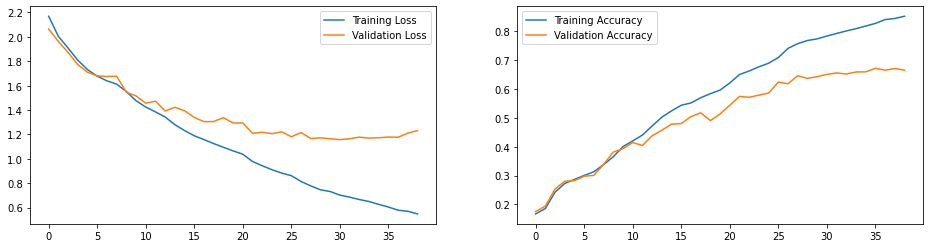

In [ ]:
## Loss and acuracy
plot_history(history_3)

In [ ]:
## Confusion matrix
pred_3= model_3.predict(x_test_norm)
pred_3=np.argmax(pred_3, axis=1)

313/313 [==============================] - 0s 1ms/step


313/313 [==============================] - 0s 1ms/step


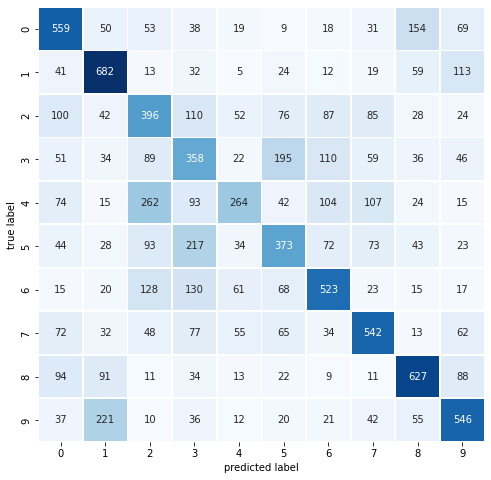

In [ ]:
# Get the predicted classes:
pred_classes_3 = np.argmax(model_3.predict(x_test_norm), axis=-1)
pred_classes_3;

conf_mx_3 = tf.math.confusion_matrix(y_test, pred_classes_3)
conf_mx_3;

plot_confusion_matrix(y_test,pred_classes_3)

#### Activation and Performance

In [ ]:
# Extracts the outputs of all layers:
layer_outputs_3 = [layer.output for layer in model_3.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_3 = models.Model(inputs=model_3.input, outputs=layer_outputs_3)

# Get activation values for the last dense layer
activations_3 = activation_model_3.predict(x_valid_norm[:3250])
dense_layer_activations_3 = activations_3[-3]
output_layer_activations_3 = activations_3[-1]

102/102 [==============================] - 0s 1ms/step


In [ ]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_3 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_3 = tsne_3.fit_transform(dense_layer_activations_3)

# Scaling
tsne_results_3 = (tsne_results_3 - tsne_results_3.min()) / (tsne_results_3.max() - tsne_results_3.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 3250 samples in 0.252s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 2.929008
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.756409
[t-SNE] KL divergence after 300 iterations: 2.319003


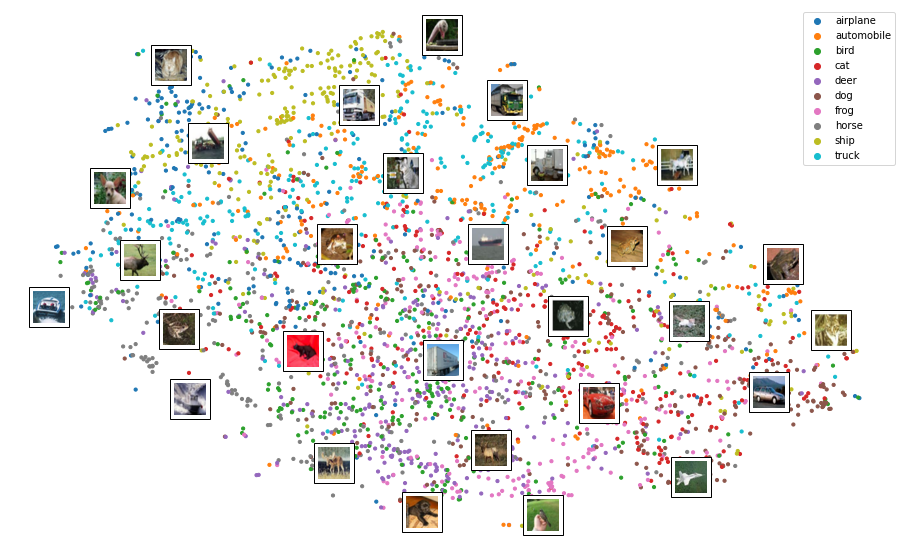

In [ ]:
cmap_3 = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter_3 = plt.scatter(tsne_results_3[:,0],tsne_results_3[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_3)
plt.legend(handles=scatter_3.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_3):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#### Predictions

In [ ]:
model_3 = tf.keras.models.load_model('CNN_model.h5')
preds_3 = model_3.predict(x_test_norm)
preds_3.shape

313/313 [==============================] - 1s 2ms/step


(10000, 10)

In [ ]:
cm_3 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df_3 = pd.DataFrame(preds_3[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df_3.style.format("{:.2%}").background_gradient(cmap=cm_3)

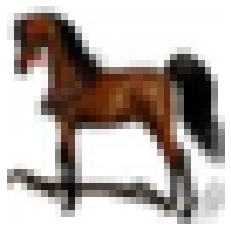

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img_3 = test_images[2004]
img_tensor_3 = image.img_to_array(img_3)
img_tensor_3 = np.expand_dims(img_tensor_3, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img_3, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs_3 = [layer.output for layer in model_3.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_3 = models.Model(inputs=model_3.input, outputs=layer_outputs_3)

In [ ]:
activations_3 = activation_model_3.predict(img_tensor_3)
len(activations_3)

1/1 [==============================] - 0s 99ms/step


7

In [ ]:
layer_names = []
for layer in model_3.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten_2',
 'dense_5',
 'dense_6']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


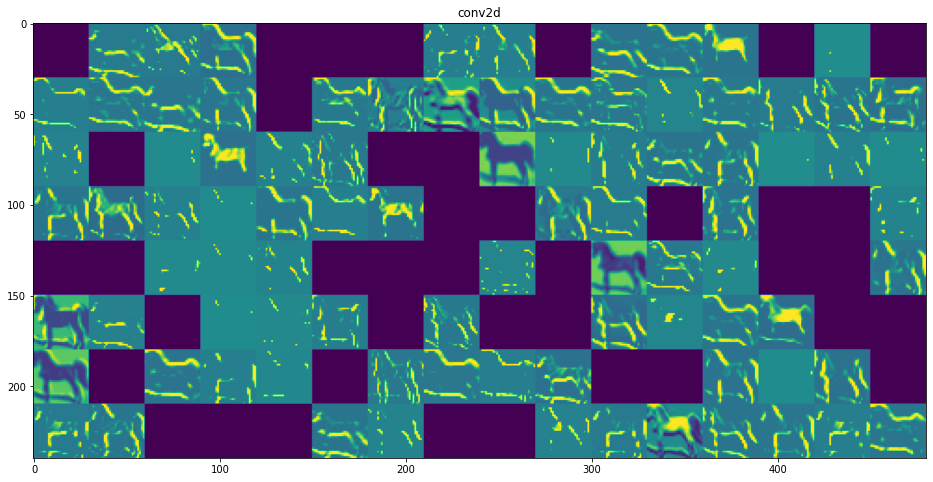

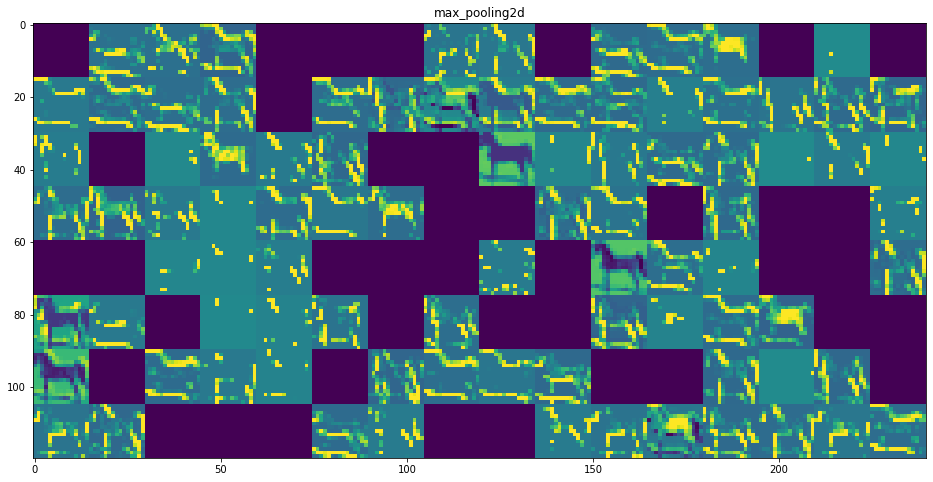

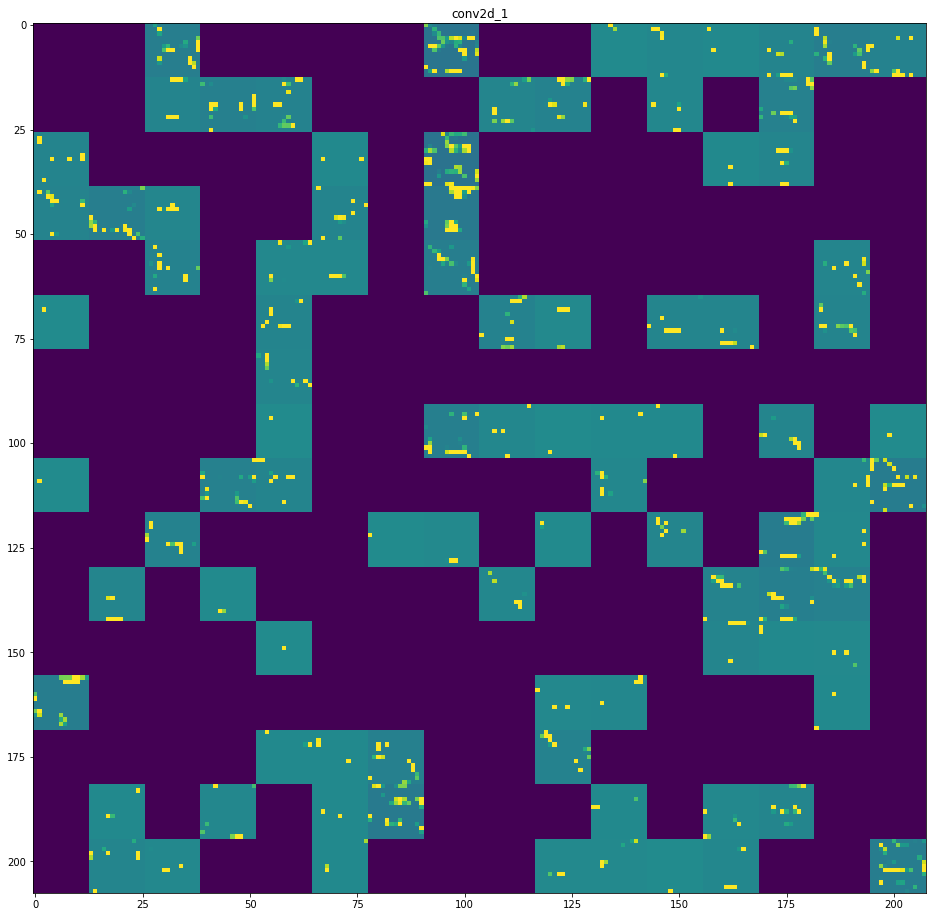

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_3.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_3):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

##Experiment 4: CNN with 2 convolution/max pooling layers (no regularization)

Layer 1: 128

Layer 2: 256

Layer 3: 512

Layer: 384

#### Build, Compile, Train, Evaluate

In [ ]:
## Build CNN

model_4 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)        

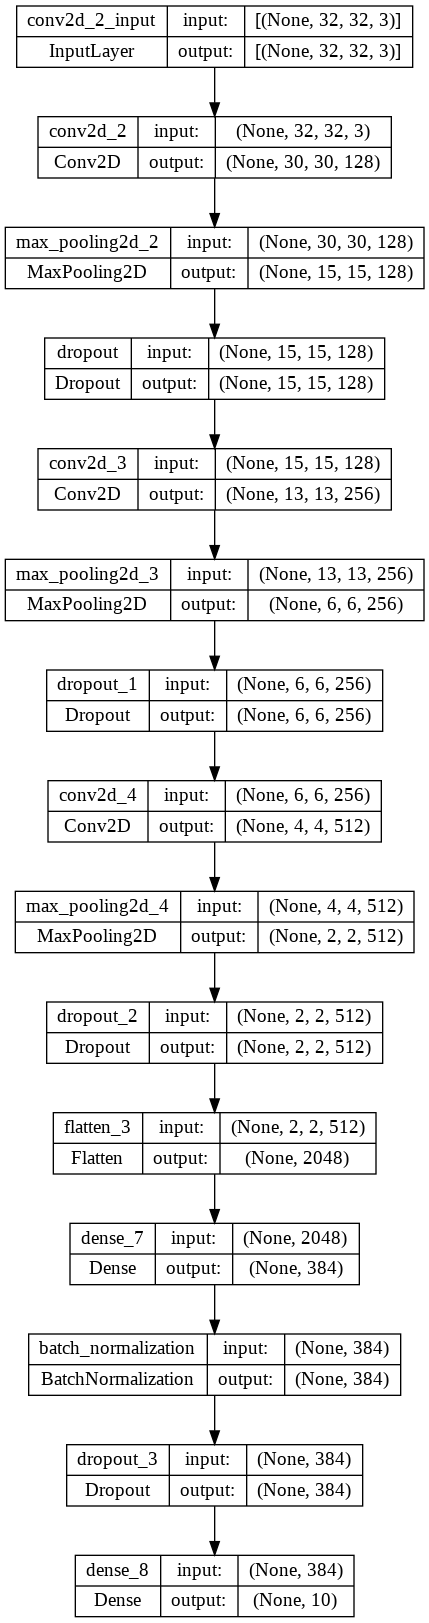

In [ ]:
keras.utils.plot_model(model_4, "CIFAR10.png", show_shapes=True) 

In [ ]:
## Compile
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train
history_4 = model_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 12ms/step - loss: 1.7012 - accuracy: 0.4053 - val_loss: 1.3751 - val_accuracy: 0.5394
Epoch 2/200
704/704 [==============================] - 8s 12ms/step - loss: 1.3398 - accuracy: 0.5539 - val_loss: 1.1513 - val_accuracy: 0.6176
Epoch 3/200
704/704 [==============================] - 8s 12ms/step - loss: 1.1957 - accuracy: 0.6127 - val_loss: 1.1536 - val_accuracy: 0.6202
Epoch 4/200
704/704 [==============================] - 8s 12ms/step - loss: 1.0983 - accuracy: 0.6531 - val_loss: 0.9883 - val_accuracy: 0.6886
Epoch 5/200
704/704 [==============================] - 8s 12ms/step - loss: 1.0360 - accuracy: 0.6748 - val_loss: 0.9962 - val_accuracy: 0.6848
Epoch 6/200
704/704 [==============================] - 8s 12ms/step - loss: 0.9831 - accuracy: 0.6954 - val_loss: 0.9375 - val_accuracy: 0.7136
Epoch 7/200
704/704 [==============================] - 8s 12ms/step - loss: 0.9373 - accuracy: 0.7145 - val_loss: 0.9144 - val_accuracy

In [ ]:
## Evalute

model_4 = tf.keras.models.load_model("CNN_model.h5")
print(f"Test acc: {model_4.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.7922 - accuracy: 0.7643
Test acc: 0.764


#### Plot Metrics

In [ ]:
history_dict_4 = history_4.history
history_dict_4.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df_4=pd.DataFrame(history_dict_4)
history_df_4.tail().round(3)

loss  accuracy  val_loss  val_accuracy
10  0.831     0.750     0.817         0.758
11  0.808     0.758     0.772         0.770
12  0.792     0.764     0.809         0.758
13  0.771     0.771     0.761         0.769
14  0.760     0.775     0.789         0.762

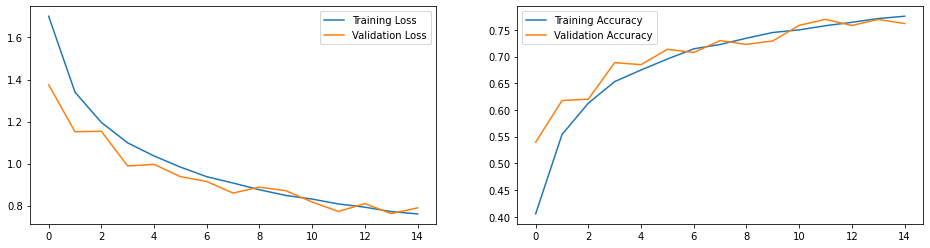

In [ ]:
## Loss and acuracy
plot_history(history_4)

In [ ]:
## Confusion matrix
pred_4= model_4.predict(x_test_norm)
pred_4=np.argmax(pred_4, axis=1)

313/313 [==============================] - 1s 3ms/step


313/313 [==============================] - 1s 3ms/step


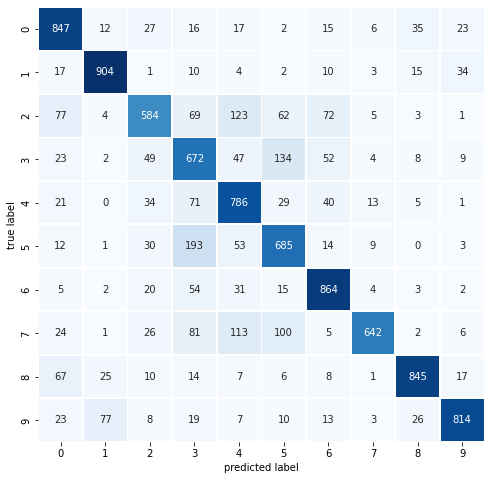

In [ ]:
# Get the predicted classes:
pred_classes_4 = np.argmax(model_4.predict(x_test_norm), axis=-1)
pred_classes_4;

conf_mx_4 = tf.math.confusion_matrix(y_test, pred_classes_4)
conf_mx_4;

plot_confusion_matrix(y_test,pred_classes_4)

#### Activation and Performance

In [ ]:
# Extracts the outputs of all layers:
layer_outputs_4 = [layer.output for layer in model_4.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_4 = models.Model(inputs=model_4.input, outputs=layer_outputs_4)

# Get activation values for the last dense layer
activations_4 = activation_model_4.predict(x_valid_norm[:3250])
dense_layer_activations_4 = activations_4[-3]
output_layer_activations_4 = activations_4[-1]

102/102 [==============================] - 0s 3ms/step


In [ ]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_4 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_4 = tsne_3.fit_transform(dense_layer_activations_4)

# Scaling
tsne_results_3 = (tsne_results_3 - tsne_results_3.min()) / (tsne_results_3.max() - tsne_results_3.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.002s...
[t-SNE] Computed neighbors for 3250 samples in 0.290s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 1.032490
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.182045
[t-SNE] KL divergence after 300 iterations: 1.684736


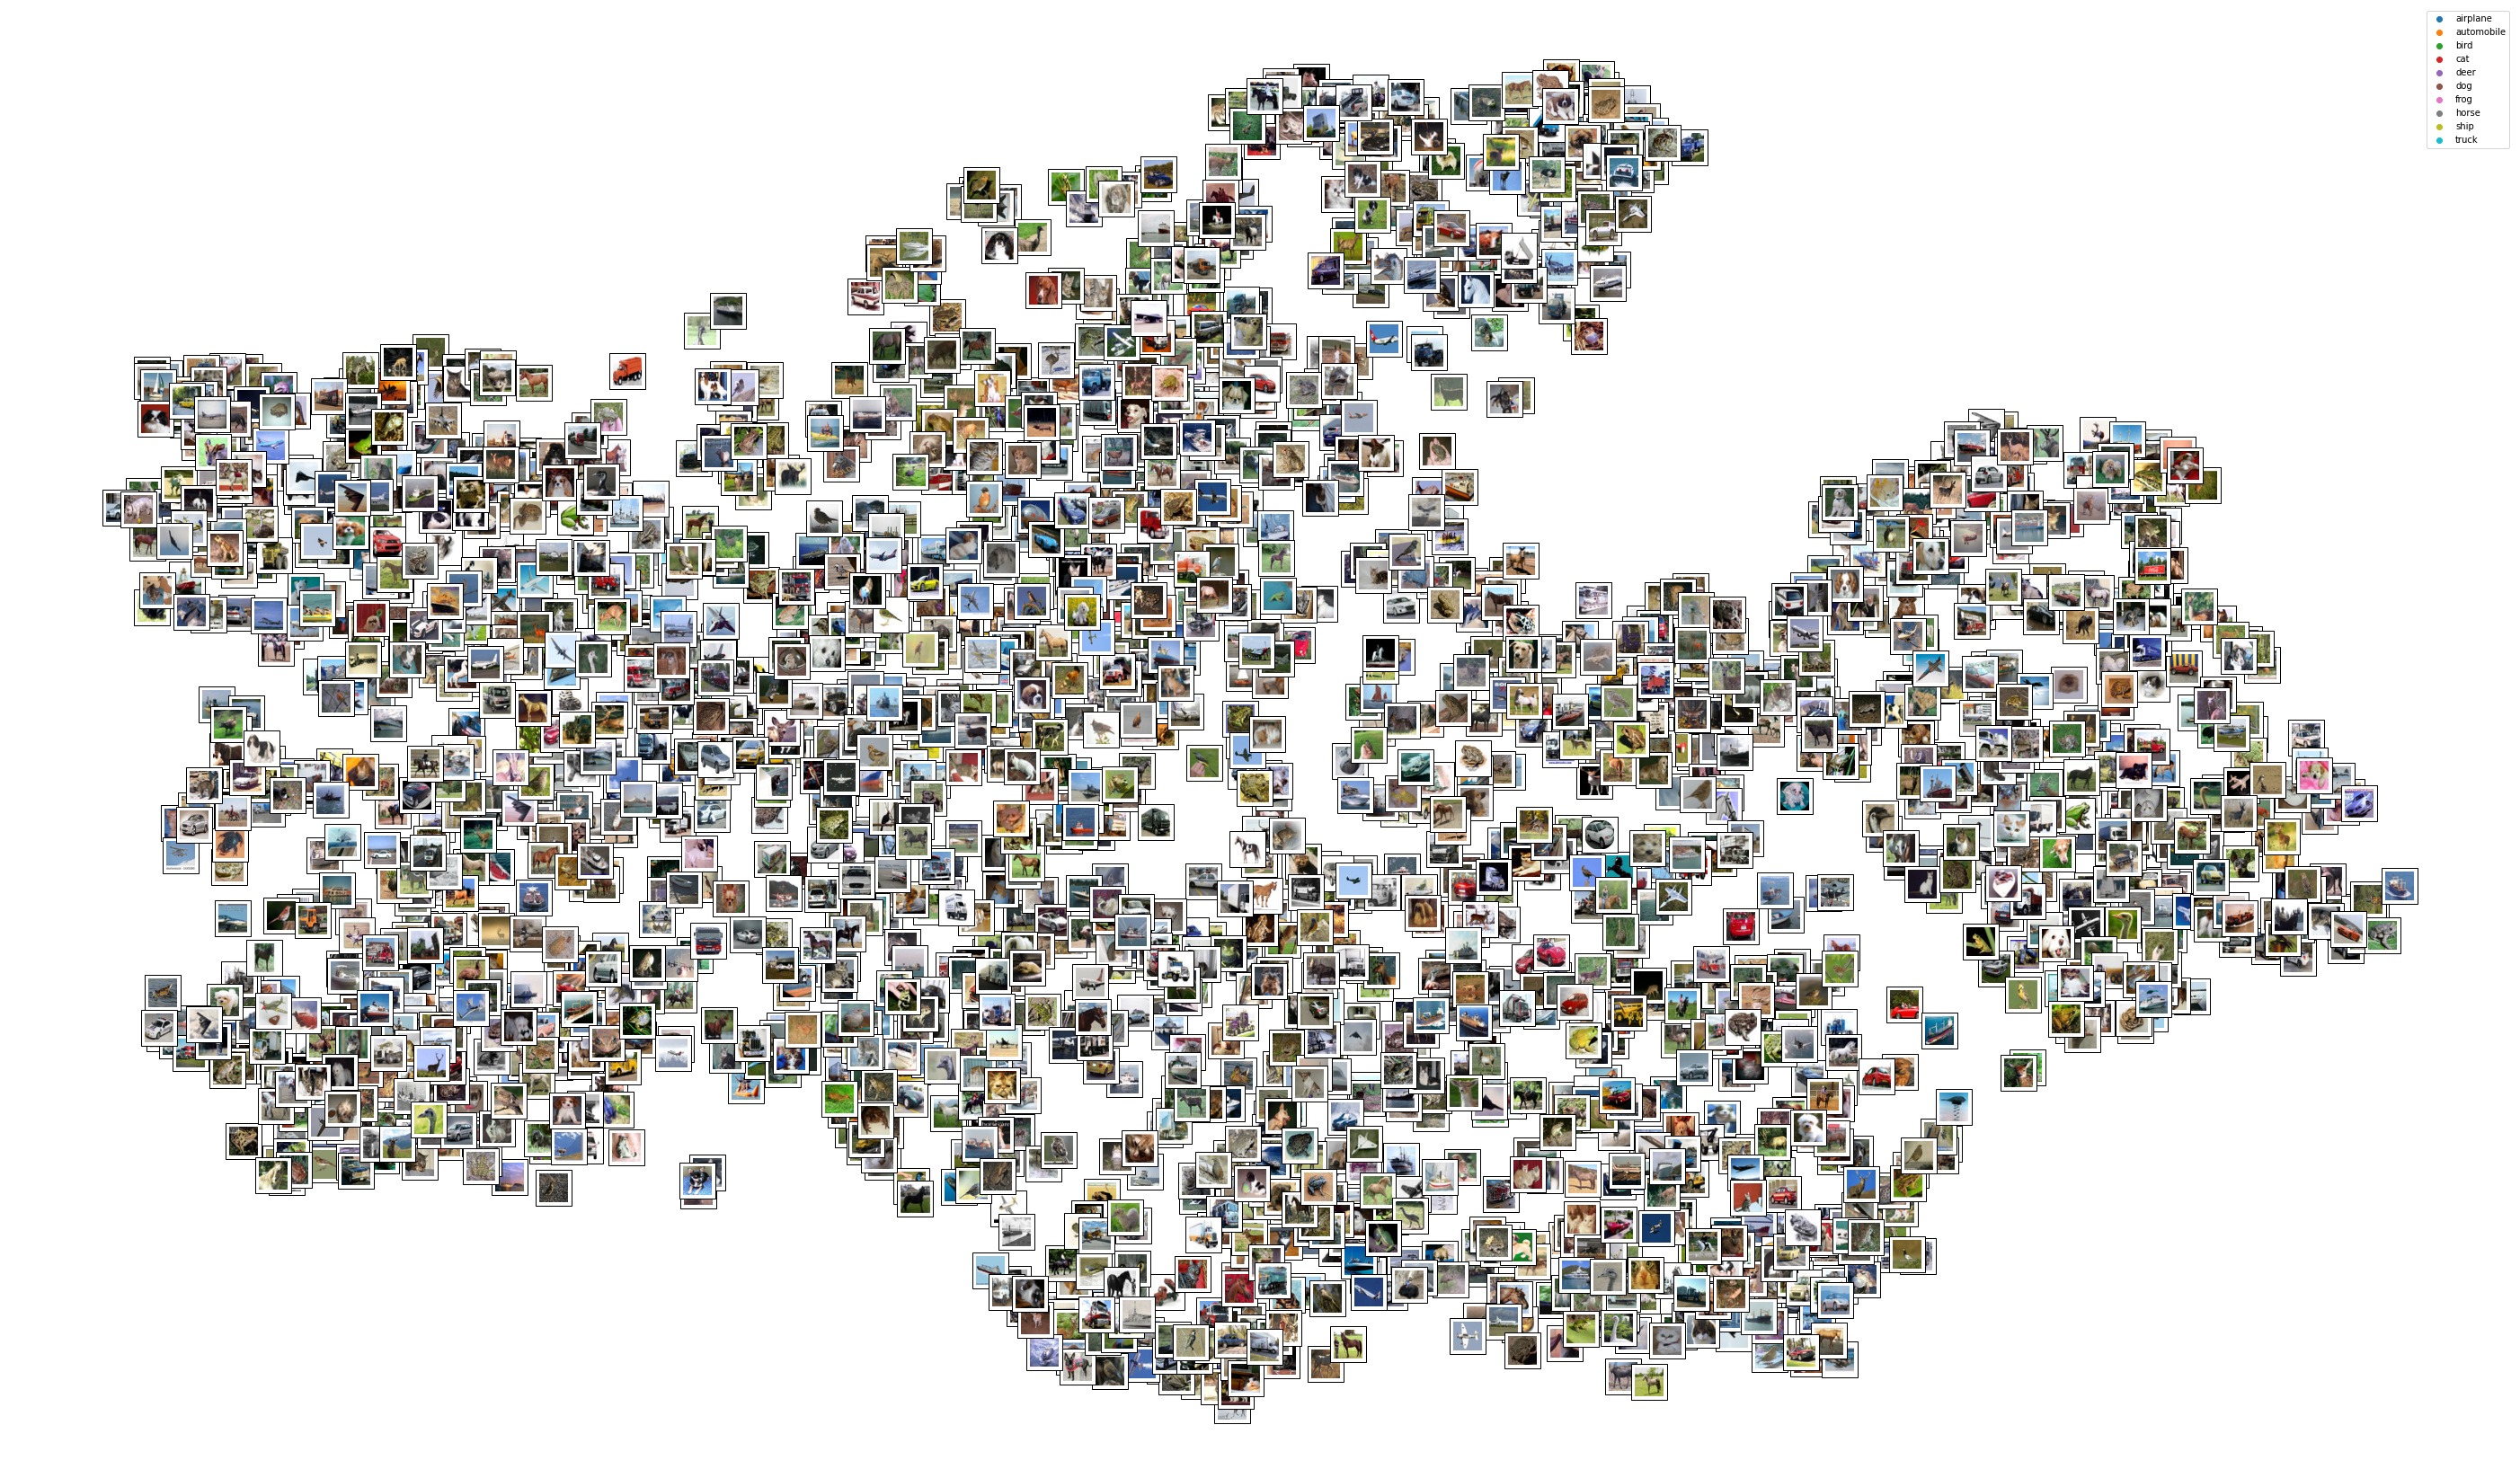

In [ ]:
cmap_4 = plt.cm.tab10
plt.figure(figsize=(50,30))
scatter_4 = plt.scatter(tsne_results_4[:,0],tsne_results_4[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_4)
plt.legend(handles=scatter_4.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_4):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#### Predictions

In [94]:
model_4 = tf.keras.models.load_model('CNN_model.h5')
preds_4 = model_4.predict(x_test_norm)
preds_4.shape

313/313 [==============================] - 1s 3ms/step


(10000, 10)

In [95]:
cm_4 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [96]:
df_4= pd.DataFrame(preds_4[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df_4.style.format("{:.2%}").background_gradient(cmap=cm_4)

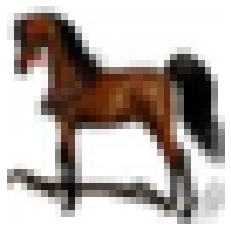

In [99]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img_4 = test_images[2004]
img_tensor_4 = image.img_to_array(img_4)
img_tensor_4 = np.expand_dims(img_tensor_4, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img_4, cmap='viridis')
plt.axis('off')
plt.show()

In [100]:
# Extracts the outputs of the top 8 layers:
layer_outputs_4 = [layer.output for layer in model_4.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_4 = models.Model(inputs=model_4.input, outputs=layer_outputs_4)

In [101]:
activations_4 = activation_model_4.predict(img_tensor_4)
len(activations_4)

1/1 [==============================] - 0s 58ms/step


8

In [103]:
layer_names = []
for layer in model_4.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d_2',
 'max_pooling2d_2',
 'dropout',
 'conv2d_3',
 'max_pooling2d_3',
 'dropout_1',
 'conv2d_4',
 'max_pooling2d_4',
 'dropout_2',
 'flatten_3',
 'dense_7',
 'batch_normalization',
 'dropout_3',
 'dense_8']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


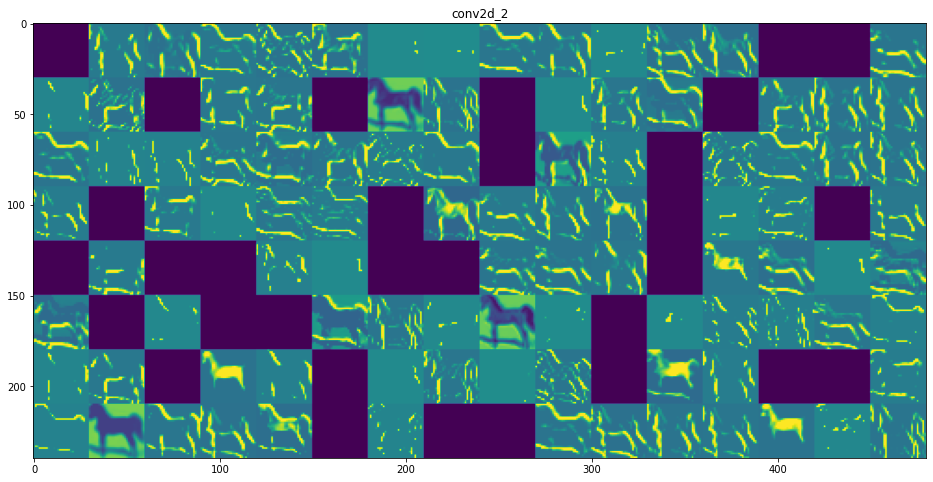

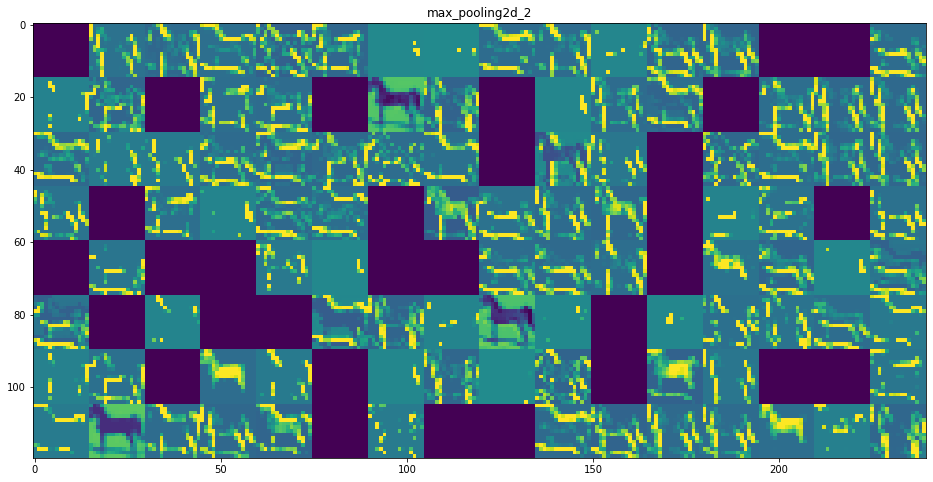

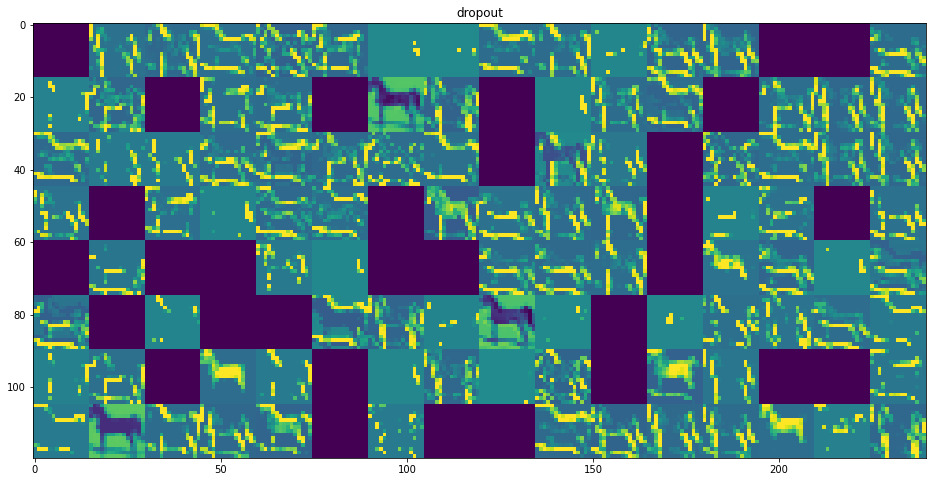

In [104]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_4.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_4):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();